<a href="https://colab.research.google.com/github/seven320/-Target_on_with_Arduino/blob/master/carprice_prediction_002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# コンペ情報

-  コンペ名: [中古車の価格予測チャレンジ](https://signate.jp/competitions/1055)
-  コンペホスト:  [signate]
-  データタイプ:  [テーブル]
-  予測するデータ: 中古車の価格
-  評価指標: MAPE

In [3]:
COMP_BASE = "signate" #["kaggle", "signate", "probspace"]
COMP_NAME = "Carprice_prediction" # コンペ名

# 環境準備

In [4]:
import os, sys
COLAB = "google.colab" in sys.modules

if COLAB:
    from google.colab import drive
    from google.colab import output
    drive.mount("/content/drive")

Mounted at /content/drive


### 環境確認

In [5]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [6]:
!python3 -V

Python 3.10.6


### ライブラリimport

In [7]:
if COLAB:
    !pip install transformers > /dev/null
    !pip install einops > /dev/null
    !pip install optuna > /dev/null
    !pip install pyephem > /dev/null
    !pip install xgboost==1.4.0 > /dev/null
    !pip install lightgbm==3.3.5 > /dev/null
    !pip install kaggle > /dev/null
    !pip install delayed > /dev/null
    !pip install -U scikit-learn > /dev/null
    !pip install Cython > /dev/null
    !pip install catboost > /dev/null
    !pip install tabpfn > /dev/null
    # 今回のコンペで追加したライブラリ

    output.clear()

In [8]:
import copy, gc, json, math, os, pickle, random, re, time, warnings, logging
from contextlib import contextmanager
from typing import Dict, List, Optional, Tuple, Type, TypeVar
from requests import get
from socket import gethostname, gethostbyname


# モデル
from catboost import CatBoostRegressor, CatBoostClassifier
from lightgbm import LGBMClassifier, log_evaluation
import lightgbm as lgb
from xgboost import XGBRegressor, XGBClassifier
from tabpfn import TabPFNClassifier

import datetime
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
# import scipy.stats
import seaborn as sns
import torch
import torch.nn as nn
from cycler import cycler
from matplotlib.colors import ListedColormap
from matplotlib.ticker import MaxNLocator
from pathlib import Path
from requests import get
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from transformers import AdamW, get_cosine_schedule_with_warmup

# 今回のコンペに必要なコード
from IPython.display import display
if not(COLAB):
    import cudf

/usr/local/lib/python3.10/dist-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [9]:
#############
## Utility ##
#############
@contextmanager
def timer(name: str):
    t0 = time.time()
    print(f"[{name}] start")
    yield
    print(f"[{name}] done - elapsed {time.time() - t0:.2f}s")

### ファイル作成

In [10]:
if COMP_BASE == "kaggle":
    !cp /content/drive/MyDrive/kaggle/kaggle.json /root/.kaggle/kaggle.json
    import kaggle

if COLAB:
    ip = gethostbyname(gethostname()) # 172.28.0.12
    NOTEBOOK_NAME = get(f'http://{ip}:9000/api/sessions').json()[0]['name']

    print(NOTEBOOK_NAME)

carprice_prediction_002.ipynb


In [11]:
if COLAB:
    BASE_DIR = f"/content/drive/MyDrive/{COMP_BASE}/{COMP_NAME}"

    INPUT_DIR = Path(os.path.join(BASE_DIR ,f"input"))
    INPUT_DIR.mkdir(exist_ok=True, parents=True)

    SAVE_DIR = Path(os.path.join(BASE_DIR ,f"models/{NOTEBOOK_NAME}"))
    SAVE_DIR.mkdir(exist_ok=True, parents=True)

    OOF_DIR = Path(os.path.join(BASE_DIR, f"oof/{NOTEBOOK_NAME}"))
    OOF_DIR.mkdir(exist_ok=True, parents = True)

    SUB_DIR = Path(os.path.join(BASE_DIR, f"submission/{NOTEBOOK_NAME}"))
    SUB_DIR.mkdir(exist_ok=True, parents = True)
else:
    BASE_DIR = ".."

# コンペ情報

# コンペconfig

In [12]:
NUM_FOLDS = 5
NUM_TRIALS = 1
DEBUG = True
SECOND_STG = False
PREPROCESS = False
GPU = False

In [13]:
# KAGGLE ONLY HAS 1, BUT OFFLINE, YOU CAN USE MORE
if GPU:
    os.environ["CUDA_VISIBLE_DEVICES"]="0" #0,1,2,3 for four gpu

In [14]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results

    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def set_seed(seed = 0):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

### データのロード

In [15]:
# csvファイルの場合
%%time
if COLAB:
    train_df = pd.read_csv(os.path.join(BASE_DIR, "input/train.csv"))
    print(train_df.shape)
    test_df = pd.read_csv(os.path.join(BASE_DIR, "input/test.csv"))
    print(test_df.shape)

(27532, 16)
(27537, 15)
CPU times: user 177 ms, sys: 43 ms, total: 220 ms
Wall time: 641 ms


#コンペのコード

### モデル定義

In [16]:
class AbstractFeatureTransformer:
    def __init__(self):
        self.name = self.__class__.__name__

    def fit_transform(self, input_df: pd.DataFrame, y=None):
        self.fit(input_df, y)
        return self.transform(input_df)

    def fit(self, input_df: pd.DataFrame, y=None):
        pass

    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        raise NotImplementedError

Transformer = TypeVar("Transformer", bound=AbstractFeatureTransformer)

def extract_features(input_df: pd.DataFrame,
                     transformers: List[Transformer],
                     fit: bool = True,
                     logger: Optional[logging.Logger] = None):
    feature_dfs = []
    for transformer in transformers:
        # timerはブロックの実行時間を計測するユーティリティ
        with timer(f"Extract features with {transformer.name}", logger):
            if fit:
                feature_dfs.append(transformer.fit_transform(input_df))
            else:
                feature_dfs.append(transformer.transform(input_df))
    all_features = pd.concat(feature_dfs, axis=1)
    return all_features

In [17]:
class AbstractTreeModel:
    def __init__(self, prediction_type="regression"):
        self.model = None
        self.prediction_type = prediction_type

    def train(self,
              params: dict,
              X_train: pd.DataFrame,
              y_train: np.ndarray,
              X_val: pd.DataFrame,
              y_val: np.ndarray,
              train_weights: Optional[np.ndarray] = None,
              val_weights: Optional[np.ndarray] = None,
              train_params: Optional[dict] = None):
        if train_params is None:
            train_params = {}

        model = self._train(
            params,
            X_train, y_train,
            X_val, y_val,
            train_weights, val_weights,
            train_params)
        self.model = model
        return self

    def _train(self,
               params,
               X_train,
               y_train,
               X_val,
               y_val,
               train_weights,
               val_weights,
               train_params):
        raise NotImplementedError

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        raise NotImplementedError

    @property
    def feature_names_(self):
        raise NotImplementedError

    @property
    def feature_importances_(self):
        raise NotImplementedError

    def _check_if_trained(self):
        assert self.model is not None, "You need to train the model first"

class LGBModel(AbstractTreeModel):
    def _train(self,
               params,
               X_train, y_train,
               X_val, y_val,
               train_weights, val_weights,
               train_params):
        trn_data = lgb.Dataset(X_train, y_train, weight=train_weights)
        val_data = lgb.Dataset(X_val, y_val, weight=val_weights)
        model = lgb.train(params=params,
                          train_set=trn_data,
                          valid_sets=[trn_data, val_data],
                          **train_params,)
                        #   verbose_eval=False)
        return model

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        self._check_if_trained()
        return self.model.predict(X, num_iteration=self.model.best_iteration)

    @property
    def feature_names_(self):
        self._check_if_trained()
        return self.model.feature_name()

    @property
    def feature_importances_(self):
        self._check_if_trained()
        return self.model.feature_importance(importance_type="gain")

class XGBModel(AbstractTreeModel):
    def _train(self,
               params,
               X_train, y_train,
               X_val, y_val,
               train_weights, val_weights,
               train_params):
        model = XGBRegressor(**params,
            )

        model.fit(X_train, y_train,
                  eval_set = [(X_val, y_val)],
                  **train_params
                  )

        return model

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        self._check_if_trained()
        return self.model.predict(X, self.model.get_best_iteraion())

    @property
    def feature_names_(self):
        self._check_if_trained()
        # return self.use_cols

    @property
    def feature_importances_(self):
        self._check_if_trained()
        return self.model.feature_importances_

class CatBoostModel(AbstractTreeModel):
    def _train(self,
               params,
               X_train, y_train,
               X_val, y_val,
               train_weights, val_weights,
               train_params):


        trn_data = cb.Pool(X_train, y_train)
        val_data = cb.Pool(X_val, y_val)

        model = CatBoostRegressor(**params)
        model.fit(X_train,
                  y_train,
                  eval_set = val_data,
                  **train_params
        )

        return model

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        self._check_if_trained()
        return self.model.predict(X)

    @property
    def feature_names_(self):
        self._check_if_trained()
        # return self.use_cols

    @property
    def feature_importances_(self):
        self._check_if_trained()
        return self.model.feature_importances_

class TabPfnModel(AbstractTreeModel):
    def _train(self,
               params,
               X_train, y_train,
               X_val, y_val,
               train_weights, val_weights,
               N_ensemble_configurations = 64):

        model = TabPFNClassifier(N_ensemble_configurations, device='cuda:0')
        model.fit(X_train,
                  y_train
        )

        return model

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        self._check_if_trained()
        return self.model.predict(X)


def get_tree_model(name: str) -> Type[AbstractTreeModel]:
    DEFINED_MODELS = {
        "lgb": LGBModel,
        "xgb": XGBModel,
        "cat": CatBoostModel,
    }
    model = DEFINED_MODELS.get(name)
    if model is None:
        raise ValueError(
            """Invalid model name: {}.
            Pre-defined model names are as follows: {}""".format(
                name,
                ",".join(DEFINED_MODELS.keys())
            ))
    return model

In [18]:
def viz_feature_importances(feature_importances: pd.DataFrame)-> None:
    fi_gby = feature_importances.groupby("feature").agg({
        "importance": ["mean", "std"]
    }).sort_values(("importance", "mean"), ascending=0).index
    plt.figure(figsize=(30, 20))

    sns.barplot(x="importance", y="feature", data=feature_importances, order=fi_gby)

    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

### 前処理

In [19]:
class Numericals(AbstractFeatureTransformer):
    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        cols = [pd.api.types.is_numeric_dtype(dtype) for dtype in input_df.dtypes]
        return input_df.loc[:, cols]

class LabelEncoding(AbstractFeatureTransformer):
    def __init__(self, columns: List[str]):
        super().__init__()
        self.le_columns = columns
        self.encoders = {
            column: LabelEncoder()
            for column in self.le_columns
        }
        self.__is_fitted = False

    def fit(self, input_df: pd.DataFrame, y: Optional[np.ndarray] = None):
        """
        ラベルに変換する前に欠損値を埋める
        """
        for column in self.le_columns:
            self.encoders[column].fit(input_df[column].fillna(""))
        self.__is_fitted = True

    def transform(
        self,
        input_df: pd.DataFrame,
        y: Optional[np.ndarray] = None
    ) -> pd.DataFrame:
        assert self.__is_fitted, "You need to call `fit` first."
        encoded = {}
        for column in self.le_columns:
            encoded[column] = self.encoders[column].transform(
                input_df[column].fillna(""))
        return pd.DataFrame(encoded)

In [20]:
train_df.head()

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price
0,0,nashville,1949,bmw,excellent,6 cylinders,gas,115148,clean,manual,rwd,mid-size,convertible,orange,NaN,27587
1,1,state college,2013,toyota,fair,8 cylinders,gas,172038,clean,automatic,rwd,full-size,sedan,silver,pa,4724
2,2,wichita,1998,ford,good,6 cylinders,gas,152492,clean,automatic,fwd,full-size,SUV,silver,ks,10931
3,3,albany,2014,ford,excellent,4 cylinders,gas,104118,clean,manual,fwd,mid-size,SUV,blue,ny,16553
4,4,redding,2005,ford,excellent,6 cylinders,gas,144554,clean,manual,fwd,mid-size,sedan,red,ca,5158


In [21]:
def preprocess(train_df: pd.DataFrame, test_df: pd.DataFrame) -> List[pd.DataFrame]:

    p_train_df = copy.deepcopy(train_df)
    p_test_df = copy.deepcopy(test_df)

    # ラベルに変換する物
    # todo 名寄せ
    label_columns = ["region", "manufacturer", "condition", "cylinders", "fuel", "title_status", "transmission", "drive", "size", "type", "paint_color", "state"]
    le = LabelEncoding(columns = label_columns)
    le.fit(pd.concat([train_df, test_df]))

    train_df_ = le.transform(train_df)
    test_df_ = le.transform(test_df)

    p_train_df[label_columns] = train_df_[label_columns]
    p_test_df[label_columns] = test_df_[label_columns]

    return p_train_df, p_test_df

In [22]:
p_train_df, p_test_df = preprocess(train_df, test_df)

### 学習



In [23]:
train_df.head()

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price
0,0,nashville,1949,bmw,excellent,6 cylinders,gas,115148,clean,manual,rwd,mid-size,convertible,orange,NaN,27587
1,1,state college,2013,toyota,fair,8 cylinders,gas,172038,clean,automatic,rwd,full-size,sedan,silver,pa,4724
2,2,wichita,1998,ford,good,6 cylinders,gas,152492,clean,automatic,fwd,full-size,SUV,silver,ks,10931
3,3,albany,2014,ford,excellent,4 cylinders,gas,104118,clean,manual,fwd,mid-size,SUV,blue,ny,16553
4,4,redding,2005,ford,excellent,6 cylinders,gas,144554,clean,manual,fwd,mid-size,sedan,red,ca,5158


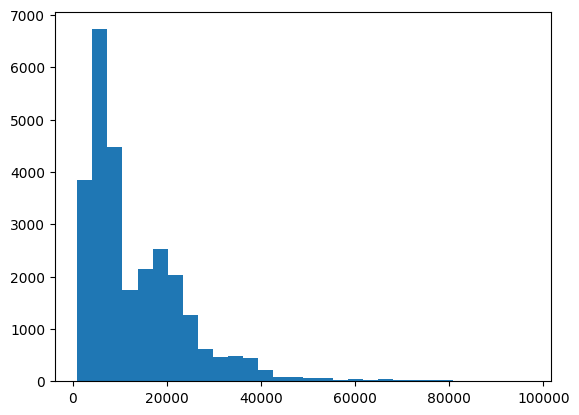

In [24]:
plt.hist(train_df["price"], bins = 30)
plt.show()

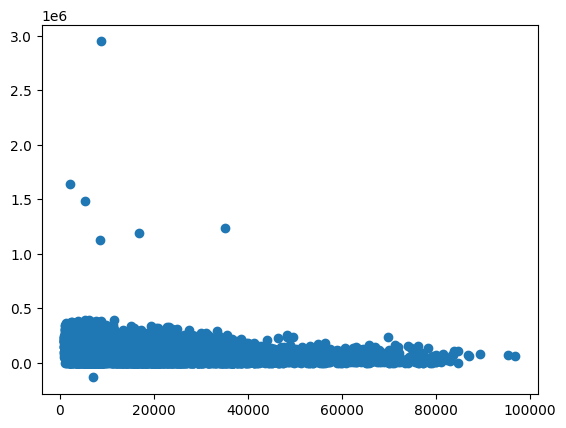

In [25]:
plt.scatter(train_df["price"], train_df["odometer"])
plt.show()

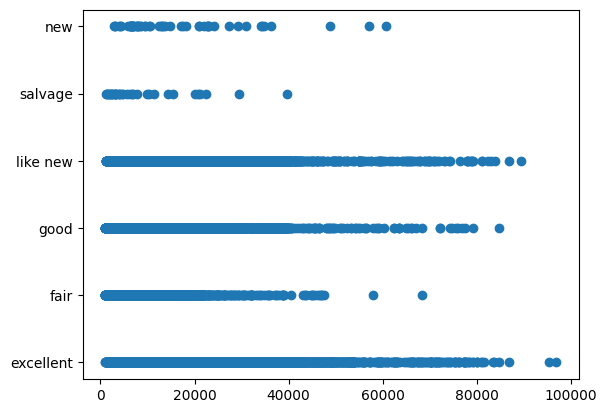

In [26]:
plt.scatter(train_df["price"], train_df["condition"])
plt.show()

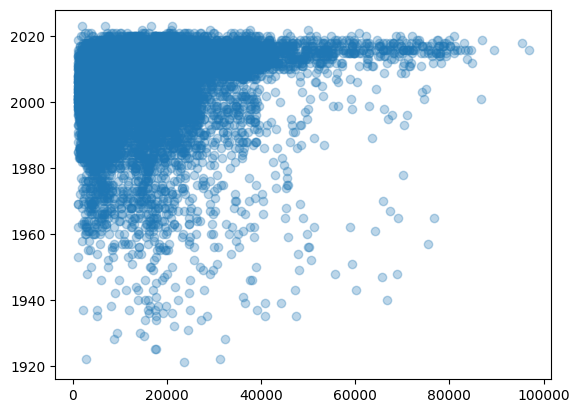

In [27]:
plt.scatter(train_df["price"], np.clip(train_df["year"], 2023, 0), alpha = 0.3)
plt.show()

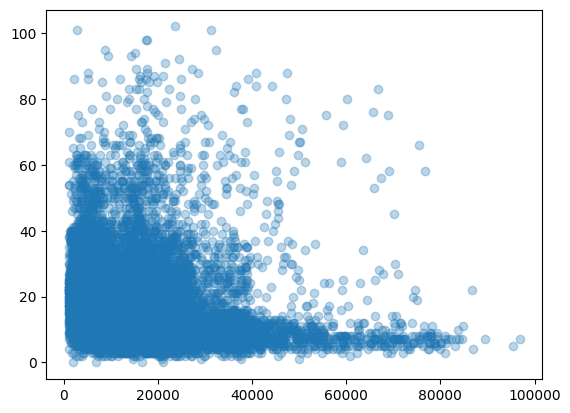

In [28]:
plt.scatter(train_df["price"], 2023 - np.clip(train_df["year"], 2023, 0), alpha = 0.3)
plt.show()

In [29]:
train_df["price"]

0        27587
1         4724
2        10931
3        16553
4         5158
         ...  
27527    32212
27528     5400
27529    22227
27530     3054
27531    20801
Name: price, Length: 27532, dtype: int64

In [30]:
# Set predictor and target columns
target = 'price'
predictors = [n for n in train_df.columns if n != target and n not in ["Id"] ] # remove target and unnecessary features

print(predictors)

['id', 'region', 'year', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state']


In [31]:
if GPU:
    device = "gpu"

In [32]:
lgb_params= {
        'boosting': 'gbdt',
        # 'objective': 'rmse'
        "objective": "mape",
        "metric": "mape",
        'learning_rate': 0.00685,
        "max_depth": 8,
        "num_leaves": 64,
        'subsample': 0.7,
        'subsample_freq': 1,
        "min_data_in_leaf":30,
        "device": "gpu" if GPU else "cpu",
        "seed":2022,
}

lgb_train_params = {
    "num_boost_round": 20000,
    "callbacks": [
                  lgb.early_stopping(stopping_rounds= 500, verbose=False),
                  lgb.log_evaluation(period = 500)
    ]
}

In [33]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

final_preds = []
warnings.simplefilter('ignore')

oof_df = train_df[["price"]]
oof_df["predict"] = -1
models = []

for i, (train_index,val_index) in enumerate(skf.split(train_df, train_df["price"])):
    X_train, X_val = p_train_df.loc[train_index, predictors], p_train_df.loc[val_index, predictors]
    y_train, y_val = p_train_df.loc[train_index, "price"], p_train_df.loc[val_index, "price"]

    model = get_tree_model("lgb")()
    model.train(
            params = lgb_params,
            train_params = lgb_train_params,
            X_train = X_train,
              y_train = y_train,
              X_val = X_val,
              y_val = y_val
              )

    # save model
    with open(os.path.join(SAVE_DIR, f"model_{i}.pkl"), "wb") as p:
        pickle.dump(model, p)
    models.append(model)

    oof = model.predict(X_val)

    oof_score = mean_absolute_percentage_error(oof, y_val)
    print(f"oof MAPE{oof_score: .4f}")

    oof_df.loc[val_index, "predict"] = oof

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.192787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1036
[LightGBM] [Info] Number of data points in the train set: 22025, number of used features: 15
[LightGBM] [Info] Start training from score 5271.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	training's mape: 0.429203	valid_1's mape: 0.454549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

In [34]:
oof_score = mean_absolute_percentage_error(oof_df["price"], oof_df["predict"])
print(f"oof MAPE{oof_score: .4f}")

oof MAPE 0.4506


In [35]:
def viz_feature_importances(feature_importances: pd.DataFrame)-> None:
    fi_gby = feature_importances.groupby("feature").agg({
        "importance": ["mean", "std"]
    }).sort_values(("importance", "mean"), ascending=0).index
    plt.figure(figsize=(30, 20))

    sns.barplot(x="importance", y="feature", data=feature_importances, order=fi_gby)

    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

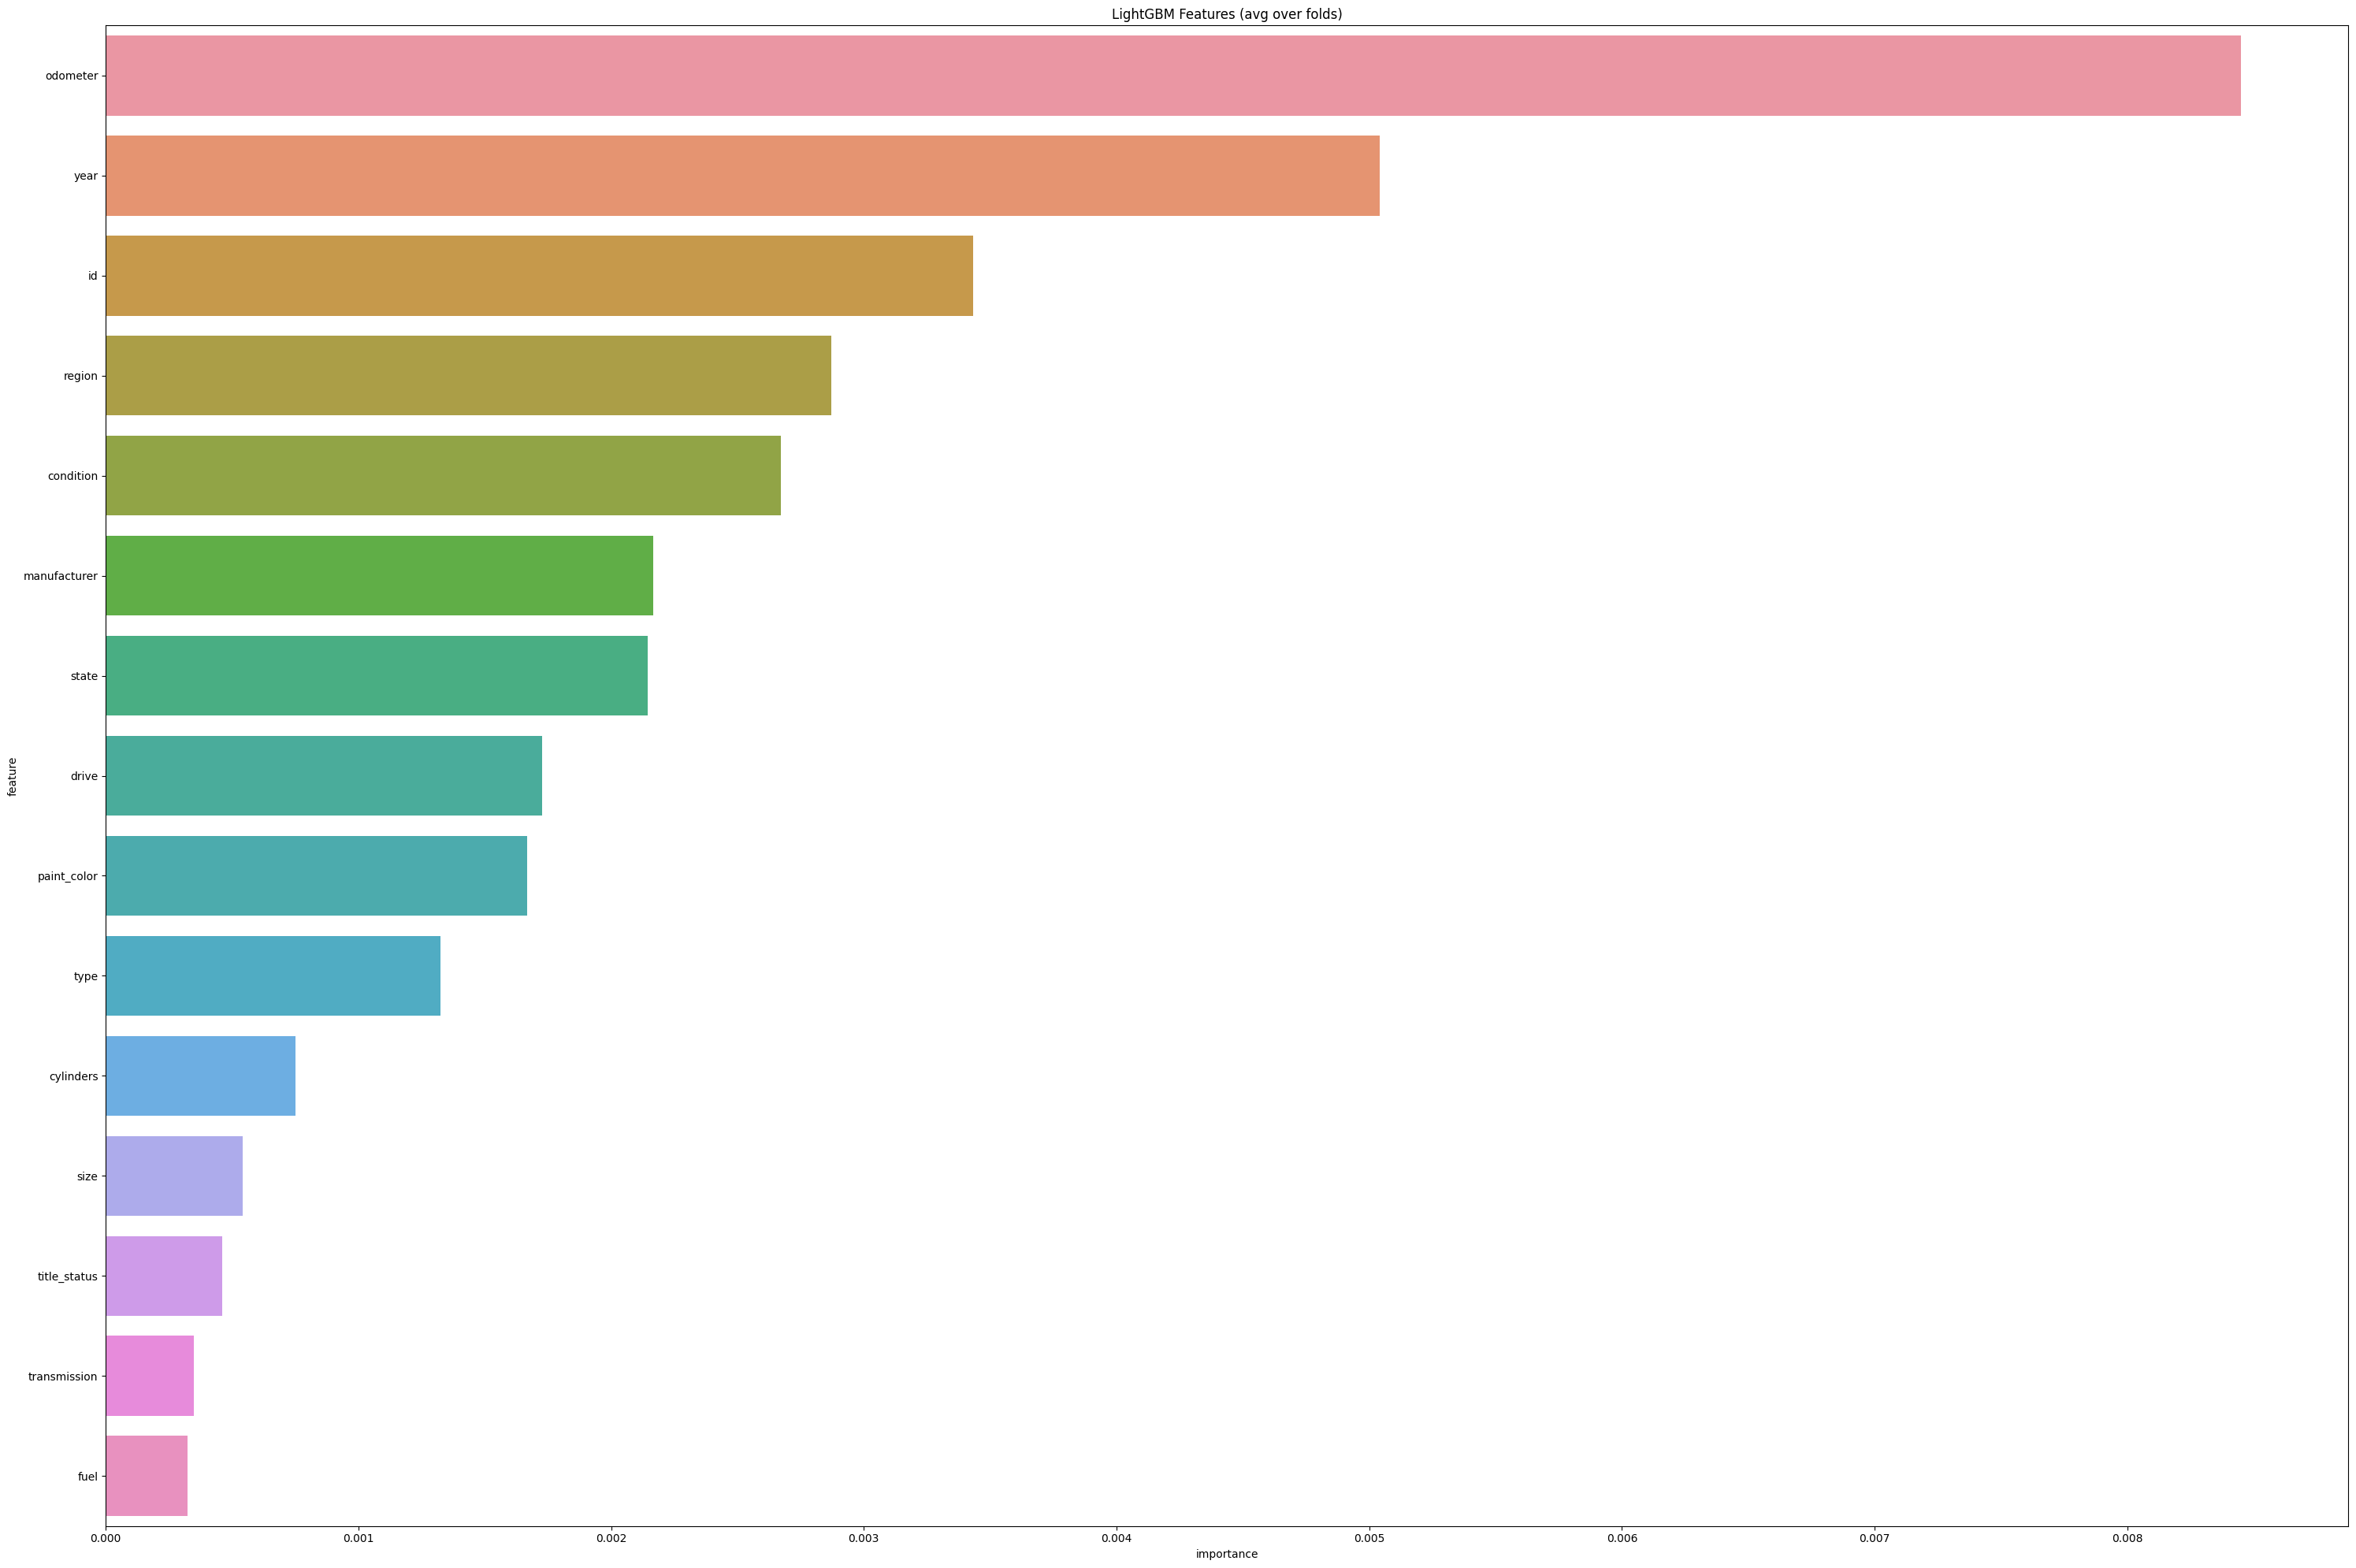

In [36]:
feature_importance = pd.DataFrame()
feature_importance["feature"] = models[0].feature_names_
feature_importance["importance"] = models[0].feature_importances_

viz_feature_importances(feature_importance)

### 後処理

### 推論

In [37]:
predicts = np.zeros((len(models), p_test_df.shape[0]))
for i, model in enumerate(models):
    predict = model.predict(p_test_df[predictors])
    predicts[i] = predict

In [38]:
submit_df = pd.read_csv(os.path.join(BASE_DIR, "input/submit_sample.csv"), header = None)
submit_df[1] = predicts.mean(axis = 0)

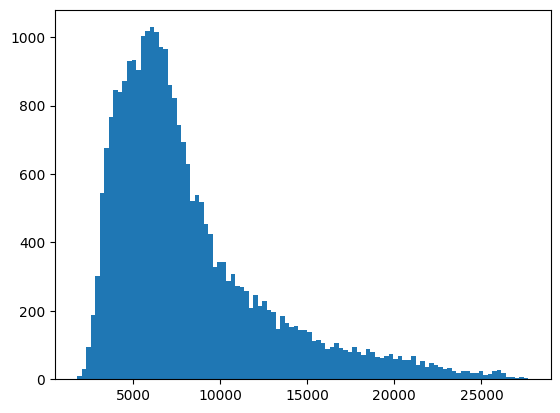

In [39]:
plt.hist(submit_df[1], bins = 100)
plt.show()


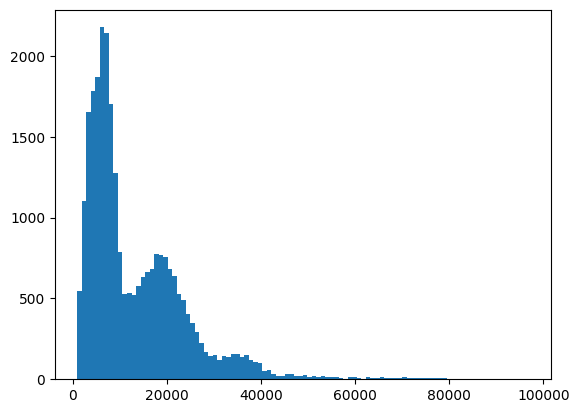

In [40]:
plt.hist(train_df["price"], bins = 100)
plt.show()

In [41]:
submit_df.to_csv(os.path.join(SUB_DIR, "submission.csv"), index= False, header = False)
submission_file = os.path.join(SUB_DIR, "submission.csv")

### 提出

In [42]:
### kaggleにおいてファイル提出が可能な場合
if COMP_BASE == "kaggle":
    !kaggle competitions submit -c {COMP_NAME} -f submission.csv -m {NOTEBOOK_NAME}
elif COMP_BASE == "signate":
    !pip install signate > /dev/null
    !mkdir /root/.signate
    !cp /content/drive/MyDrive/signate/signate.json /root/.signate/signate.json
    !signate submit --competition-id=1055 {submission_file} --note {NOTEBOOK_NAME}

You have successfully submitted your predictions.We will send you the submission result to your email address.
